In [3]:
# Downloading the dataset

# import os

# os.system("wget https://www.timeseriesclassification.com/aeon-toolkit/LSST.zip")
# os.mkdir("LSST")
# os.rename("LSST.zip", "LSST/LSST.zip")
# os.system("unzip LSST/LSST.zip -d LSST")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys

sys.path.append("..")

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import arff
import os
import torch
from sktime.datasets import load_from_tsfile

In [ ]:
dataset_path = "LSST"

train_file = os.path.join(dataset_path, f"LSST_TRAIN.ts")
X_train, y_train = load_from_tsfile(train_file, return_data_type="numpy3D")

test_file = os.path.join(dataset_path, f"LSST_TEST.ts")
X_test, y_test = load_from_tsfile(test_file, return_data_type="numpy3D")

y_train = np.unique(y_train, return_inverse=True)[1] + 1
y_test = np.unique(y_test, return_inverse=True)[1] + 1

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (2459, 36, 6) (2459,)
Test shape: (2466, 36, 6) (2466,)


In [8]:
from sklearn.preprocessing import StandardScaler

batch_size, seq_len, n_dim = X_train.shape
test_batch_size = X_test.shape[0]

scl = StandardScaler()

X_train_reshaped = X_train.reshape(-1, n_dim)
X_test_reshaped = X_test.reshape(-1, n_dim)

X_train_scaled = scl.fit_transform(X_train_reshaped)
X_test_scaled = scl.transform(X_test_reshaped)

X_train = X_train_scaled.reshape(batch_size, seq_len, n_dim)
X_test = X_test_scaled.reshape(test_batch_size, seq_len, n_dim)

In [17]:
from torch_mas.batch.trainer import BaseTrainer
from torch_mas.batch.internal_model import NClass
from torch_mas.batch.activation_function import BaseActivation
from torch_mas.batch.trainer.learning_rules import (
    IfActivated,
    IfNoActivated,
    IfNoActivatedAndNoNeighbors,
    SimpleDestroy,
)
from torch_mas.data import DataBuffer
from sklearn.metrics import accuracy_score

_, seq_len, input_dim = X_train.shape


internal_nodel = NClass(
    input_dim=input_dim,
    output_dim=1,
    memory_length=input_dim + 1,
)

activation = BaseActivation(
    seq_len=seq_len,
    input_dim=input_dim,
    output_dim=1,
    alpha=0.03,
    neighbor_rate=0.8,
)

trainer = BaseTrainer(
    activation=activation,
    internal_model=internal_nodel,
    R=0.1,
    imprecise_th=0.015,
    bad_th=0.01,
    n_epochs=5,
    learning_rules=[
        IfNoActivatedAndNoNeighbors(),
        IfNoActivated(),
        IfActivated(),
        SimpleDestroy(20000),
    ],
)

dataset = DataBuffer(X_train, y_train)

n_samples = len(dataset)
for e in range(trainer.n_epochs):

    n_agents = trainer.n_agents
    indices = torch.arange(n_samples)
    shuffled_indices = indices[torch.randperm(indices.size(0))]
    batches = shuffled_indices.split(32)
    for batch in batches:
        X, y = dataset[batch]
        trainer.partial_fit(X, y)

    print(f"Epoch {e}, Agents {trainer.n_agents}, {(trainer.n_agents - n_agents):+d}")
    n_agents = trainer.n_agents

Epoch 0, Agents 2251, +2251
Epoch 1, Agents 4381, +2130
Epoch 2, Agents 6532, +2151
Epoch 3, Agents 8694, +2162
Epoch 4, Agents 10856, +2162


In [18]:
y_pred = []
for batch in torch.tensor(X_test).split(32):
    y_pred += trainer.predict(batch).tolist()

accuracy_score(y_pred, y_test)

0.2818329278183293

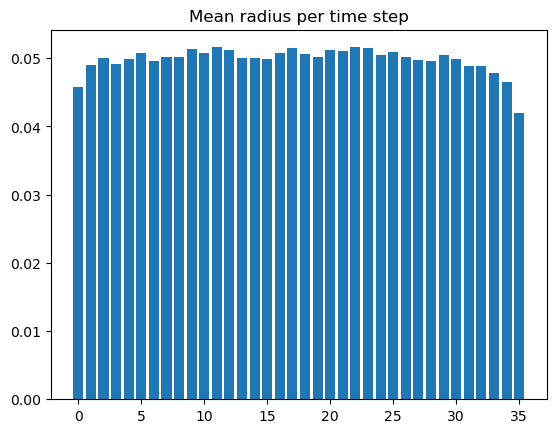

In [22]:
import matplotlib.pyplot as plt

plt.bar(
    np.arange(36),
    (activation.orthotopes[:, :, :, 1] - activation.orthotopes[:, :, :, 0])
    .mean(dim=-1)
    .mean(dim=0),
)

plt.title("Mean radius per time step")
plt.show()

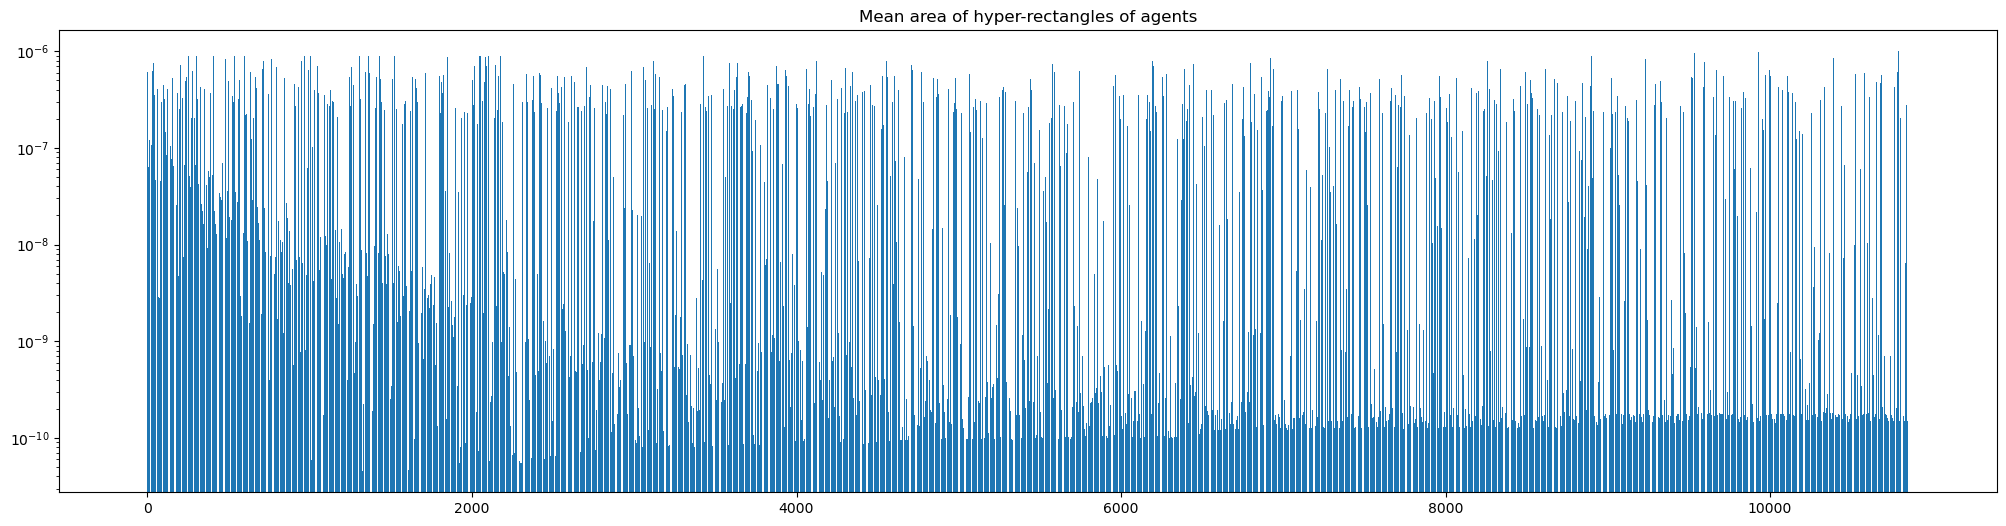

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25, 6))

ax.bar(
    np.arange(trainer.n_agents),
    (activation.orthotopes[:, :, :, 1] - activation.orthotopes[:, :, :, 0])
    .prod(dim=-1)
    .mean(dim=-1),
)

plt.title("Mean area of hyper-rectangles of agents")
plt.yscale("log")
plt.show()

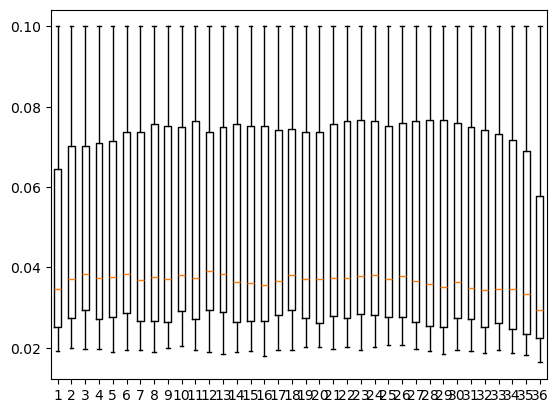

In [21]:
plt.boxplot(
    (activation.orthotopes[::, :, :, 1] - activation.orthotopes[:, :, :, 0]).mean(
        dim=-1
    ),
)
plt.show()

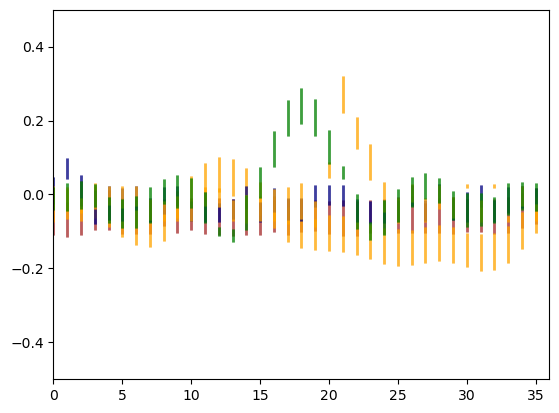

In [29]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

fig, ax = plt.subplots()
colors = [
    "red",
    "blue",
    "green",
    "purple",
    "orange",
    "grey",
    "magenta",
    "brown",
    "cyan",
    "lime",
    "pink",
    "gold",
    "navy",
    "teal",
]
orthotopesdim0 = activation.orthotopes[30:35, :, 1, :]

for agent_id in range(orthotopesdim0.shape[0]):
    y = internal_nodel.base_prediction[agent_id]

    lines = []
    for time in range(orthotopesdim0[agent_id].shape[0]):
        for h in range(orthotopesdim0[agent_id][time].shape[0]):
            lines.append(
                [
                    (time, orthotopesdim0[agent_id][time][0]),
                    (time, orthotopesdim0[agent_id][time][1]),
                ]
            )
    lc = LineCollection(lines, linewidths=2, colors=colors[int(y)], alpha=0.5)
    ax.add_collection(lc)

ax.set_xlim(0, 36)
ax.set_ylim(-0.5, 0.5)
plt.show()